### Grid Search Cross Validation

Grid Search Cross Validation은 사용자 정의 점수 함수에 따라 교차 검증 성과를 최대화하는 파라미터 조합을 완전 탐색을 통해 수행한다. 기저 데이터 구조에 대해 잘 모를 경우 가장 먼저 취할 수 있는 합리적인 방법이다. `scikit-learn`은 이 방법을 `GridSearchCV` 함수로 구현했는데 교차 검증 생성자를 인수로 받는다. Chapter 7에서 설명했던 이유로 `GridSearchCV`가 누출된 정보로 Machine Learning 추정기를 과적합하는 것을 방지하려면 `PurgedKFold` Class를 전달해야 한다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_test_data(
        n_features : int = 40,
        n_informative : int = 10,
        n_redundant : int = 10,
        n_samples : int = 10000,
        random_state : int = 42,
        sigma_std : float = 0.0
) : 
    from sklearn.datasets import make_classification
    
    np.random.seed(random_state)
    
    trnsX, cont = make_classification(
        n_samples = n_samples,
        n_features = n_features,
        n_informative = n_informative,
        n_redundant = n_redundant,
        random_state = random_state,
        shuffle = False
    )
    
    df0_index = pd.date_range(start = pd.to_datetime('today') - pd.to_timedelta(n_samples, unit = 'd'), 
                              periods = n_samples, freq = 'B')

    trnsX, cont = pd.DataFrame(trnsX, index = df0_index), pd.Series(cont, index=df0_index).to_frame('bin')

    df0 = ['I_' + str(i) for i in range(n_informative)] + ['R_' + str(i) for i in range(n_redundant)]
    df0 += ['N_' + str(i) for i in range(n_features - len(df0))]
    
    trnsX.columns = df0
    cont['w'] = 1. / cont.shape[0]
    cont['t1'] = pd.Series(cont.index, index = cont.index)
    
    return trnsX, cont

testing = False
n_samples = 1000
n_splits = 3

trnsX, cont = get_test_data(
    n_features = 20,
    n_informative = 10,
    n_redundant = 5,
    n_samples = n_samples,
)

In [3]:
cont.head()

,bin,w,t1
2021-11-15 23:17:26.629275,0,0.001,2021-11-15 23:17:26.629275
2021-11-16 23:17:26.629275,0,0.001,2021-11-16 23:17:26.629275
2021-11-17 23:17:26.629275,0,0.001,2021-11-17 23:17:26.629275
2021-11-18 23:17:26.629275,0,0.001,2021-11-18 23:17:26.629275
2021-11-19 23:17:26.629275,0,0.001,2021-11-19 23:17:26.629275


In [4]:
from sklearn.svm import SVC
from FinancialMachineLearning.cross_validation.cross_validation import clf_hyper_fit
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    trnsX, 
    cont, 
    test_size = 0.3, 
    shuffle = False
)

In [5]:
from sklearn.ensemble import BaggingClassifier
from FinancialMachineLearning.cross_validation.cross_validation import FMLPipeline

base_estimator = SVC(
    random_state = 42, 
    probability = True
)

pipe_clf = FMLPipeline(
    [
        (
            'clf', 
            BaggingClassifier(
                estimator = base_estimator, 
                random_state = 42
            )
        )
    ]
)

param_grid = {
    'clf__n_estimators': [10, 50, 100],
    'clf__max_samples': [0.5, 0.7, 1.0],
    'clf__max_features': [0.5, 0.7, 1.0],
    'clf__estimator__C': [0.1, 1, 10],
    'clf__estimator__kernel': ['linear', 'rbf'],
}

In [6]:
samples_info_sets = y_train['t1']

fitted_model = clf_hyper_fit(
    feat = X_train,
    label = y_train['bin'],
    samples_info_sets = samples_info_sets,
    pipe_clf = pipe_clf,
    param_grid = param_grid,
    cv = 3, 
    bagging = [0, None, 1],
    random_search_iterator = 0,
    n_jobs = 8,
    pct_embargo = 0.01
)

In [7]:
fitted_model

FMLPipeline(steps=[('clf',
                    BaggingClassifier(estimator=SVC(C=10, probability=True,
                                                    random_state=42),
                                      n_estimators=50, random_state=42))])

In [8]:
y_pred = pd.Series(
    fitted_model.predict(X_test),
    index = y_test.index
)
y_proba = pd.DataFrame(
    fitted_model.predict_proba(X_test),
    index = y_test.index,
    columns = [0, 1]
)

In [9]:
from sklearn.metrics import classification_report

print(classification_report(y_test['bin'], y_pred))

              precision    recall  f1-score   support

           0       0.26      1.00      0.41        50
           1       1.00      0.42      0.59       250

    accuracy                           0.51       300
   macro avg       0.63      0.71      0.50       300
weighted avg       0.88      0.51      0.56       300



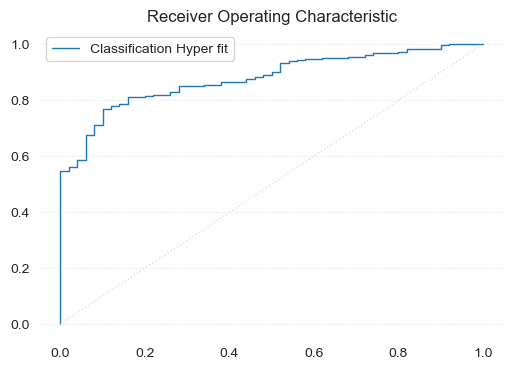

In [10]:
from sklearn.metrics import roc_curve

fpr, tpr, thres = roc_curve(y_test['bin'], y_proba[1])

fig, ax = plt.subplots(figsize = (6, 4))
ax.plot(fpr, tpr, label = 'Classification Hyper fit', lw = 1)
ax.plot(
    [0, 1], 
    [0, 1], 
    ls = ':', 
    color = 'lightgray', 
    alpha = 0.75, 
    lw = 1
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
ax.legend()
plt.title('Receiver Operating Characteristic')
plt.show()